# Amazon Fine Food Reviews Analysis

Data Source :  https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consist of reviews of fine foods from Amazon.

Number of reviews:568,454
Number of users: 256,059
Number of products:74,258
TimeSpan: Oct 1999 - oct 2012

Number of Attributes/Columns in data: 10

Attribute Information:

    1.Id
    2.ProductId - unique identifier for the product
    3.UserId - unqiue identifier for the user
    4.ProfileName
    5.HelpfulnessNumerator - number of users who found the review helpful
    6.HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
    7.Score - rating between 1 and 5
    8.Time - timestamp for the review
    9.Summary - brief summary of the review
    10.Text - text of the review



Objective:

Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).


[Q] How to determine if a review is positive or negative?

[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

# 1.0 Loading the data

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import scipy
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os


In [32]:
con = sqlite3.connect('database.sqlite') 
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 
def partition(x):
    if x < 3:
        return 0
    return 1
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


# 1.1 Exploratory Data Analysis


# 1.1.2 Data Cleaning:Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data. Following is an example:


In [33]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that

ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.


In [34]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [35]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [36]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

Observation:- It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [37]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [38]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [39]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

# 1.1.3 Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

    Begin by removing the html tags
    Remove any punctuations or limited set of special characters like , or . or # etc.
    Check if the word is made up of english letters and is not alpha-numeric
    Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
    Convert the word to lowercase
    Remove Stopwords
    Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)

After which we collect the words used to describe positive and negative reviews


In [40]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [41]:

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'only', 'has', 'she', 'other', 'itself', 'you', 'most', 'i', 'hasn', 'more', "you'll", 'of', 'both', 'with', 'been', 'couldn', 'needn', 'on', 'all', 'before', 'once', "couldn't", 'yourself', 'through', 'at', 'but', "haven't", 'my', 'can', 'am', 'some', "needn't", 'didn', 'or', 'him', 'own', 'while', 'why', 'against', 'this', 'again', 'down', "wouldn't", 'ourselves', 'does', "shouldn't", 've', 'being', 'yours', 'his', 'between', 'have', 'up', 'haven', 'during', "doesn't", 'myself', 'mightn', 'so', 'the', 'in', "mightn't", 'wouldn', 'her', 'for', 'whom', 'yourselves', 'is', 'because', 'your', 'shan', 't', 'about', 'where', 'o', 'doesn', "she's", 'himself', 'there', 'and', "it's", 'y', 'here', 'was', 'did', 'below', 'off', 'ours', "didn't", 'ain', 'theirs', 'into', 'll', "shan't", "you're", "mustn't", 'shouldn', "isn't", 'won', 'wasn', 'themselves', 'who', 'those', 'if', 'our', "weren't", 'hers', 'a', 'above', 'it', 'out', 'an', 'its', 'ma', 'no', "don't", 'he', 'few', "you'd", "wasn't",

In [42]:
if not os.path.isfile('final.sqlite'):
    final_string = []
    all_positive_words = []
    all_negative_words = []
    for i,sent in enumerate(tqdm(final['Text'].values)):
        filtered_sentence = []
        sent = cleanhtml(sent)
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):
                    if(cleaned_words.lower() not in stop):
                        s = (sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 1: 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 0:
                            all_negative_words.append(s)
        str1 = b" ".join(filtered_sentence)
        final_string.append(str1)
    #Storing data into .sqlite file
    final["CleanedText"] = final_string
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    with open('positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)
    

In [43]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

In [44]:
final_df = final.sort_values("Time")

In [45]:
final_df = final_df[0:100000]
train_df = final_df[:70000]

test_df = final_df[70000:]

In [46]:
with open('testdf.pkl', 'wb') as f:
        pickle.dump(test_df, f)
with open('traindf.pkl', 'wb') as f:
        pickle.dump(train_df, f)


# Bag of Words(BoW)

In [47]:
count_vect = CountVectorizer()
trainx = count_vect.fit_transform(train_df['CleanedText'].values)
trainy = train_df["Score"]

testx = count_vect.transform(test_df['CleanedText'].values)
test_y = test_df["Score"]

In [48]:
with open('testbow.pkl', 'wb') as f:
        pickle.dump(testx, f)
with open('trainbow.pkl', 'wb') as f:
        pickle.dump(trainx, f)


# TF_IDF

In [49]:
tf_idf_vect = TfidfVectorizer()
trainx = tf_idf_vect.fit_transform(train_df['CleanedText'].values)
#trainy = train_df["Score"]

testx = tf_idf_vect.transform(test_df['CleanedText'].values)
#test_y = test_df["Score"]


In [50]:
word2tfidf = dict(zip(tf_idf_vect.get_feature_names(), tf_idf_vect.idf_))

In [51]:
with open('word2tfidf.pkl', 'wb') as f:
        pickle.dump(word2tfidf, f)

In [52]:
with open('testtfidf.pkl', 'wb') as f:
        pickle.dump(testx, f)
with open('traintfidf.pkl', 'wb') as f:
        pickle.dump(trainx, f)


In [53]:
def list_Sentence(df):
    final = list()
    for i in df["CleanedText"].values:
        l = i.split()
        final.append(l)
    return final

In [54]:
list_train = list_Sentence(train_df)

In [55]:
from gensim.models import Word2Vec
model = Word2Vec(list_train)


# Word_2_Vec

In [56]:
def avg_w2vec(df):
    vecs = list()
    for i in tqdm(df['CleanedText']):
        length = len(i.split())
        vector = np.zeros(100)
        for word in i.split():
            try:
                x = model[word]
                vector = vector+x
            except:
                pass
                
        vector = vector/length
        vecs.append(vector)
    return vecs

In [57]:
train_avg_w2v = avg_w2vec(train_df)

100%|██████████| 70000/70000 [00:43<00:00, 1600.37it/s]


In [58]:
test_avg_w2v = avg_w2vec(test_df)

100%|██████████| 30000/30000 [00:19<00:00, 1574.17it/s]


In [59]:
with open('test_avgw2v.pkl', 'wb') as f:
        pickle.dump(test_avg_w2v, f)
with open('train_avgw2v.pkl', 'wb') as f:
        pickle.dump(train_avg_w2v, f)


In [2]:
import pickle
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
#from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn import cross_validation
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB

In [3]:
#Loading all the pickles files generated during preprocessing!!!
#1.loading avgW2Vec files:-
with open('test_avgw2v.pkl', 'rb') as f:
       test_avgw2v = pickle.load(f)
with open('train_avgw2v.pkl', 'rb') as f:
        train_avgw2v = pickle.load(f)

#2. loading tfidf files:-
with open('testtfidf.pkl', 'rb') as f:
        testtfidf = pickle.load(f)
with open('traintfidf.pkl', 'rb') as f:
        traintfidf = pickle.load(f)

#3. loading Bow files:-
with open('testbow.pkl', 'rb') as f:
        testbow = pickle.load(f)
with open('trainbow.pkl', 'rb') as f:
        trainbow = pickle.load(f)


In [4]:
with open('traindf.pkl', 'rb') as f:
        train_df = pickle.load(f)
        f.close()
with open('testdf.pkl', 'rb') as f:
        test_df = pickle.load(f)
        f.close()

# Multinomail Naive Bayes

1. Bag of Words

In [5]:
def multinomial_nb(X,Y):
    alpha = [0.00001,0.0001,0.001,0.01,0.1,1,10,1000,10000]
    cv_scores = []
    for k in alpha:
        multinomial_nb = MultinomialNB(alpha=k, fit_prior=True, class_prior=None)
        scores = cross_val_score(multinomial_nb,X,Y,cv = 10,scoring = 'roc_auc')
        cv_scores.append(scores.mean())
    #MSE = [1 - x for x in cv_scores]
    optimal_alpha = alpha[cv_scores.index(max(cv_scores))]
    print("Optimal alpha is"+" "+str(optimal_alpha))
    plt.plot(alpha,cv_scores)
    for xy in zip(alpha, np.round(cv_scores,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    plt.title("auc vs alpha")
    plt.xlabel('value of alpha')
    plt.ylabel('auc')
    plt.show()

    print("the auc for each alpha value is : ", np.round(cv_scores,3))
    return optimal_alpha


        

Optimal alpha is 0.1


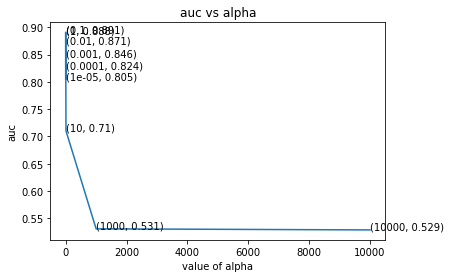

the auc for each alpha value is :  [0.805 0.824 0.846 0.871 0.891 0.888 0.71  0.531 0.529]


In [6]:
optimal_alpha = multinomial_nb(trainbow,train_df["Score"])

In [99]:
multinomial_nb_optimal = MultinomialNB(alpha=optimal_alpha, fit_prior=True, class_prior=None)
# fitting the model
multinomial_nb_optimal .fit(trainbow, train_df["Score"])
#knn_optimal.fit(bow_data, y_train)

# predict the response
pred = multinomial_nb_optimal .predict(testbow)



In [100]:
y_proabs = multinomial_nb_optimal.predict_proba(testbow)

In [101]:
auc_score = roc_auc_score(test_df["Score"],y_proabs[:,1])
print("The auc score on test data is ",auc_score)

The auc score on test data is  0.9000988523961104


In [20]:
import scikitplot as skplt
import matplotlib.pyplot as plt
#referenced from : -https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

In [103]:
y_proabs_train = multinomial_nb_optimal.predict_proba(trainbow)

# ROC curve on Test Data

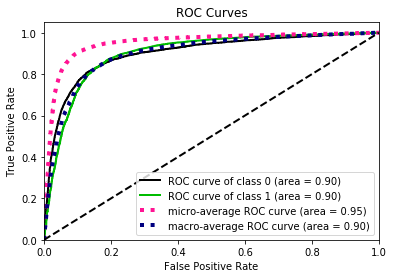

In [104]:
skplt.metrics.plot_roc_curve(test_df["Score"], y_proabs)
plt.show()

# ROC curve on Train Data

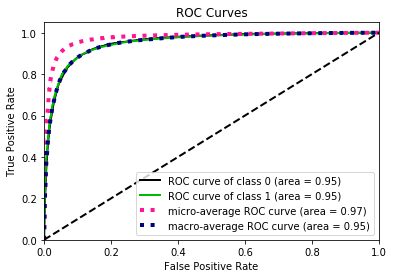

In [105]:
skplt.metrics.plot_roc_curve(train_df["Score"], y_proabs_train)
plt.show()

In [106]:
from sklearn.metrics import confusion_matrix
c_matrix = confusion_matrix(test_df["Score"], pred)
print(c_matrix)

[[ 2657  1446]
 [ 1489 24408]]


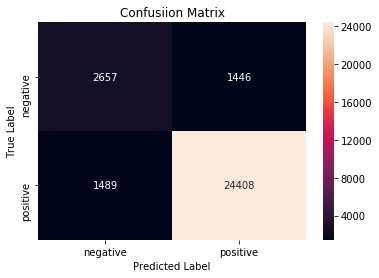

In [107]:
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(c_matrix, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Feature Importance

In [109]:
#refrence:- https://machinelearningmastery.com/better-naive-bayes/
#:-https://stackoverflow.com/questions/50526898/how-to-get-feature-importance-in-naive-bayes
neg_class_prob_sorted = multinomial_nb_optimal.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted = multinomial_nb_optimal.feature_log_prob_[1, :].argsort()
print("Negative Class")
print(np.take(count_vect.get_feature_names(), neg_class_prob_sorted[:30]))
print("Positive Class")
print(np.take(count_vect.get_feature_names(), pos_class_prob_sorted[:30]))

Negative Class
['aaa' 'nearer' 'neapolitan' 'neanderth' 'neah' 'neadless' 'nchees' 'ncaa'
 'nba' 'nazi' 'naysay' 'nayonais' 'nay' 'navrattan' 'navratan' 'navig'
 'navel' 'naval' 'nautic' 'nauseau' 'neater' 'neatest' 'neavoli' 'nebari'
 'nehi' 'negril' 'neglibl' 'negit' 'negativ' 'neelam']
Positive Class
['formual' 'centrist' 'mispres' 'mispackag' 'incarcer' 'teaspr'
 'inccompet' 'endem' 'inaud' 'teaposi' 'mishapen' 'incisor' 'inclind'
 'encymast' 'misgiv' 'incompetit' 'misfortun' 'barefruit' 'censor'
 'teeninsi' 'inadequt' 'quilti' 'imparti' 'mistreat' 'tenctones'
 'bangladeshi' 'energey' 'tempah' 'damsel' 'tem']


TF_IDF

Optimal alpha is 0.1


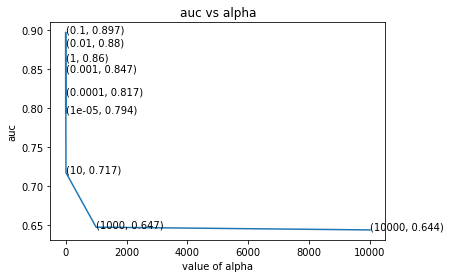

the auc for each alpha value is :  [0.794 0.817 0.847 0.88  0.897 0.86  0.717 0.647 0.644]


In [110]:
optimal_alpha = multinomial_nb(traintfidf,train_df["Score"])

In [111]:
multinomial_nb_optimal = MultinomialNB(alpha=optimal_alpha, fit_prior=True, class_prior=None)
# fitting the model
multinomial_nb_optimal .fit(traintfidf, train_df["Score"])
#knn_optimal.fit(bow_data, y_train)

# predict the response
pred = multinomial_nb_optimal .predict(testtfidf)



In [112]:
y_proabs = multinomial_nb_optimal.predict_proba(testtfidf)

In [113]:
auc_score = roc_auc_score(test_df["Score"],y_proabs[:,1])
print("The auc score on test data is ",auc_score)

The auc score on test data is  0.91589066290293


In [114]:
y_proabs_train = multinomial_nb_optimal.predict_proba(traintfidf)

# ROC curve on Test Data

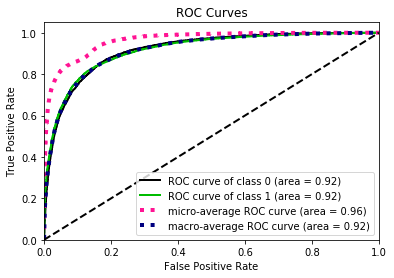

In [115]:
skplt.metrics.plot_roc_curve(test_df["Score"], y_proabs)
plt.show()

# ROC curve on Train Data

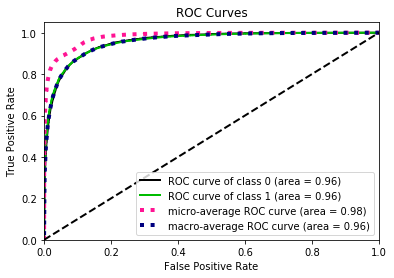

In [116]:
skplt.metrics.plot_roc_curve(train_df["Score"], y_proabs_train)
plt.show()

In [117]:
from sklearn.metrics import confusion_matrix
c_matrix = confusion_matrix(test_df["Score"], pred)
print(c_matrix)

[[  560  3543]
 [   94 25803]]


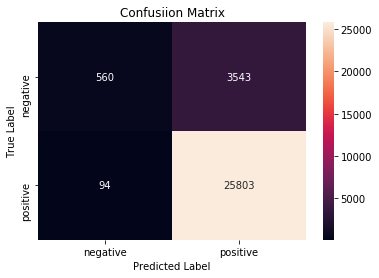

In [118]:
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(c_matrix, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Feature Importance

In [120]:
#refrence:- https://machinelearningmastery.com/better-naive-bayes/
#:-https://stackoverflow.com/questions/50526898/how-to-get-feature-importance-in-naive-bayes
neg_class_prob_sorted = multinomial_nb_optimal.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted = multinomial_nb_optimal.feature_log_prob_[1, :].argsort()
print("Negative Class")
print(np.take(tf_idf_vect.get_feature_names(), neg_class_prob_sorted[:30]))
print("Positive Class")
print(np.take(tf_idf_vect.get_feature_names(), pos_class_prob_sorted[:30]))

Negative Class
['aaa' 'nearer' 'neapolitan' 'neanderth' 'neah' 'neadless' 'nchees' 'ncaa'
 'nba' 'nazi' 'naysay' 'nayonais' 'nay' 'navrattan' 'navratan' 'navig'
 'navel' 'naval' 'nautic' 'nauseau' 'neater' 'neatest' 'neavoli' 'nebari'
 'nehi' 'negril' 'neglibl' 'negit' 'negativ' 'neelam']
Positive Class
['portfolio' 'experiencew' 'nondistict' 'solic' 'kantrowitz' 'nondistinct'
 'expet' 'expiat' 'uncoop' 'bricklik' 'nongshim' 'nonsuch' 'explanant'
 'soever' 'sodden' 'nondigest' 'asoft' 'exploratori' 'noob' 'nookl'
 'askew' 'sobey' 'normalish' 'expobar' 'expoit' 'briney' 'expoloratori'
 'kalami' 'expreienc' 'exprens']


# Feature Engineering

In [7]:
#Here along we will be using some feature engineering technique like adding the length of the reviuews~~~

length_reviews_train = train_df["Text"].apply(len)
length_reviews_train.index = [i for i in range(0,70000)]

In [8]:
length_reviews_test = test_df["Text"].apply(len)
length_reviews_test.index = [i for i in range(0,30000)]

In [9]:
Training_data = pd.DataFrame(trainbow.toarray())

In [10]:
Training_data["length"] = length_reviews_train

In [11]:
Testing_data = pd.DataFrame(testbow.toarray())

In [12]:
Testing_data["length"] = length_reviews_test

In [13]:
Testing_data.shape

(30000, 31374)

Optimal alpha is 0.1


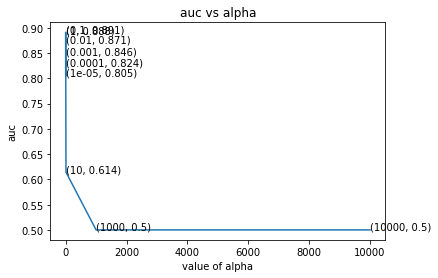

the auc for each alpha value is :  [0.805 0.824 0.846 0.871 0.891 0.888 0.614 0.5   0.5  ]


In [14]:
optimal_alpha = multinomial_nb(scipy.sparse.csr_matrix(Training_data.values),train_df["Score"])

In [15]:
multinomial_nb_optimal = MultinomialNB(alpha=optimal_alpha, fit_prior=True, class_prior=None)
# fitting the model
multinomial_nb_optimal .fit(scipy.sparse.csr_matrix(Training_data.values), train_df["Score"])
#knn_optimal.fit(bow_data, y_train)

# predict the response
pred = multinomial_nb_optimal .predict(scipy.sparse.csr_matrix(Testing_data.values))



In [16]:
y_proabs = multinomial_nb_optimal.predict_proba(scipy.sparse.csr_matrix(Testing_data.values))

In [17]:
auc_score = roc_auc_score(test_df["Score"],y_proabs[:,1])
print("The auc score on test data is ",auc_score)

The auc score on test data is  0.9001114352870812


In [18]:
y_proabs_train = multinomial_nb_optimal.predict_proba(scipy.sparse.csr_matrix(Training_data.values))

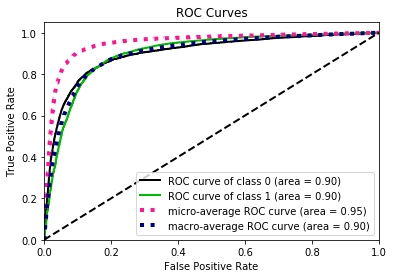

In [21]:
skplt.metrics.plot_roc_curve(test_df["Score"], y_proabs)
plt.show()

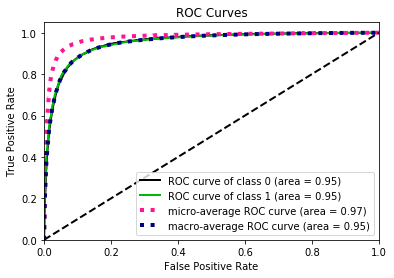

In [22]:
skplt.metrics.plot_roc_curve(train_df["Score"], y_proabs_train)
plt.show()

In [23]:
from sklearn.metrics import confusion_matrix
c_matrix = confusion_matrix(test_df["Score"], pred)
print(c_matrix)

[[ 2662  1441]
 [ 1490 24407]]


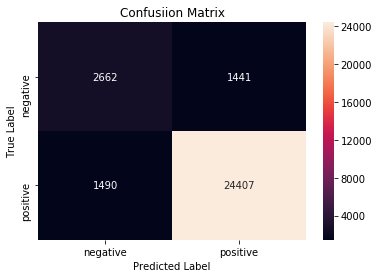

In [24]:
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(c_matrix, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()